# Analysis of COVID19 cases and deaths data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Python-code-section" data-toc-modified-id="Python-code-section-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python code section</a></span><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Key-parameters-for-analysis-go-here!" data-toc-modified-id="Key-parameters-for-analysis-go-here!-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Key parameters for analysis go here!</a></span><ul class="toc-item"><li><span><a href="#List-of-Australian-data-sources" data-toc-modified-id="List-of-Australian-data-sources-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>List of Australian data sources</a></span></li></ul></li><li><span><a href="#Common-code" data-toc-modified-id="Common-code-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Common code</a></span></li><li><span><a href="#Selected-international-comparisons---semi-log-plot-of-trajectories" data-toc-modified-id="Selected-international-comparisons---semi-log-plot-of-trajectories-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Selected international comparisons - semi-log plot of trajectories</a></span></li><li><span><a href="#Raw-death-rate-per-case" data-toc-modified-id="Raw-death-rate-per-case-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Raw death rate per case</a></span></li><li><span><a href="#Dual-case/death-horizontal-bar-charts---counts-in-leading-nations" data-toc-modified-id="Dual-case/death-horizontal-bar-charts---counts-in-leading-nations-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Dual case/death horizontal bar charts - counts in leading nations</a></span></li><li><span><a href="#New-(bar)-vs-cumulative-(line)-plots" data-toc-modified-id="New-(bar)-vs-cumulative-(line)-plots-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>New (bar) vs cumulative (line) plots</a></span></li><li><span><a href="#Analyse-new---bar-charts" data-toc-modified-id="Analyse-new---bar-charts-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Analyse new - bar charts</a></span></li><li><span><a href="#Analysis-by-differencing-and-smoothing" data-toc-modified-id="Analysis-by-differencing-and-smoothing-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Analysis by differencing and smoothing</a></span></li><li><span><a href="#Growth-factors" data-toc-modified-id="Growth-factors-2.10"><span class="toc-item-num">2.10&nbsp;&nbsp;</span>Growth factors</a></span></li><li><span><a href="#Assess-country-performance" data-toc-modified-id="Assess-country-performance-2.11"><span class="toc-item-num">2.11&nbsp;&nbsp;</span>Assess country performance</a></span></li><li><span><a href="#Swarm-plot-by-income-status" data-toc-modified-id="Swarm-plot-by-income-status-2.12"><span class="toc-item-num">2.12&nbsp;&nbsp;</span>Swarm plot by income status</a></span></li><li><span><a href="#Do-the-analysis" data-toc-modified-id="Do-the-analysis-2.13"><span class="toc-item-num">2.13&nbsp;&nbsp;</span>Do the analysis</a></span></li></ul></li><li><span><a href="#Charts-and-analytical-output-HERE!" data-toc-modified-id="Charts-and-analytical-output-HERE!-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Charts and analytical output HERE!</a></span></li><li><span><a href="#The-End." data-toc-modified-id="The-End.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The End.</a></span></li></ul></div>

## Introduction

IMPORTANT: All of the charts are in the final section of this notebook.

This work has grown enormously in the short time from its original conception. At its heart, it is an exploration of the international data on COVID19 cases and deaths. 

Some of it is descriptive statistics: for example, bar charts of cases and deaths by country.

Some of it is analytical: fitting mathematical growth models to the data from each country.

All of it is exploratory. An attempt to better understand the nature of this pandemic.

## Python code section

### Python set-up

Start with the Python imports and other set-up/initialisation stuff

In [1]:
# imports
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.optimize import curve_fit
from pathlib import Path
from io import StringIO
import datetime
import geopandas as gpd
import iso3166
import seaborn as sns

# COVID19 specific imports
sys.path.append(r'../bin')
from datagrabber import get_data, get_population_from_eu
import plotstuff as ps
from Henderson import Henderson

# display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('ggplot')

### Key parameters for analysis go here!

In [2]:
DATA_SOURCE = 'EU' # 'EU' or 'OWID'
# EU = European Centre for Disease 
#      Prevention and Control
# OWID = Our World in Data - 
#        COVID19 dataset maintained by
#        John Hopkins University

# establish a charting threshold 
def get_threshold(analytic_modality):
    return {
        'cases': 10,
        'deaths': 10
    }[analytic_modality]

# for curve fitting
MIN_DATA_REQUIRED = 7 # days
MIN_ADJ_R2_REQUIRED = 0.75
FORECAST_PERIOD = 7 # days into the future

# for smoothed growth rates
SMOOTH_WINDOW = 5 # days -- must be odd

# for smoothing the differenced data
HENDERSON_WINDOW = 15 
PLOT_2ND_DIFFERENCE = False

CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)

PLOT_SHOW = False
def plot_show():
    if PLOT_SHOW:
        plt.show()

#### List of Australian data sources

Australian Government Department of Health - updates daily at 3pm - but no history
https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers

Google sheet from the Guardian Australia
https://www.theguardian.com/news/datablog/ng-interactive/2020/mar/26/how-many-cases-of-coronavirus-are-there-in-australia-live-covid-19-numbers-and-statistics
https://docs.google.com/spreadsheets/d/1q5gdePANXci8enuiS4oHUJxcxC13d6bjMRSicakychE/edit#gid=0

The Mandarin
https://www.themandarin.com.au/127425-coronavirus-covid-19-in-australia-selection-of-infograms/

Wikipedia - says it is updated at 11.59pm every day. 
https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Australia

COVID19 in Australia
https://www.covid19data.com.au/

COVID19 in Australia https://covidlive.com.au/


### Common code

In [3]:
def decorate_plot(ax, title=None, xlabel=None, ylabel=None,
                     figsize=(8,4), tight=1, lfooter=None, 
                     rfooter=None):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = ax.figure
    if rfooter:
        fig.text(0.99, 0.01, rfooter,
                ha='right', va='bottom',
                fontsize=9, fontstyle='italic',
                color='#999999')
    if lfooter:
        fig.text(0.01, 0.01, lfooter,
                ha='left', va='bottom',
                fontsize=9, fontstyle='italic',
                color='#999999')
    fig.set_size_inches(*figsize)
    fig.tight_layout(pad=tight)
    return(fig)

In [4]:
def limit_data_cols_to_threshold(data, mode):
    threshold = get_threshold(mode)
    mask = data.iloc[-1].T >= threshold
    data = data[mask.index[mask]] 
    return(data, threshold)

### Selected international comparisons - semi-log plot of trajectories

In this section we will look how the nations at the forefront of COVID-19 are faring. We include Australia if there is sufficient data. 

A plotting and saving function

In [5]:
COUNTRY_CODES = {
    'AD': 'Andorra',
    'AE': 'United Arab Emirates',
    'AF': 'Afghanistan',
    'AG': 'Antigua & Barbuda',
    'AI': 'Anguilla',
    'AL': 'Albania',
    'AM': 'Armenia',
    'AN': 'Netherlands Antilles',
    'AO': 'Angola',
    'AQ': 'Antarctica',
    'AR': 'Argentina',
    'AS': 'American Samoa',
    'AT': 'Austria',
    'AU': 'Australia',
    'AW': 'Aruba',
    'AZ': 'Azerbaijan',
    'BA': 'Bosnia And Herzegovina',
    'BB': 'Barbados',
    'BD': 'Bangladesh',
    'BE': 'Belgium',
    'BF': 'Burkina Faso',
    'BG': 'Bulgaria',
    'BH': 'Bahrain',
    'BI': 'Burundi',
    'BJ': 'Benin',
    'BM': 'Bermuda',
    'BN': 'Brunei',   # 'Brunei Darussalam',
    'BO': 'Bolivia',
    'BR': 'Brazil',
    'BS': 'Bahamas', #
    'BT': 'Bhutan',
    'BU': 'Burma (no longer exists)',
    'BV': 'Bouvet Island',
    'BW': 'Botswana',
    'BY': 'Belarus',
    'BZ': 'Belize',
    'CA': 'Canada',
    'CC': 'Cocos (Keeling) Islands',
    'CD': 'Democratic Republic Of Congo',
    'CF': 'Central African Republic',
    'CG': 'Congo',
    'CH': 'Switzerland',
    'CI': "Cote D'Ivoire",
    'CK': 'Cook Iislands',
    'CL': 'Chile',
    'CM': 'Cameroon',
    'CN': 'China',
    'CO': 'Colombia',
    'CR': 'Costa Rica',
    'CS': 'Czechoslovakia (no longer exists)',
    'CU': 'Cuba',
    'CV': 'Cape Verde',
    'CW': 'Curaã§Ao',
    'CX': 'Christmas Island',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DD': 'German Democratic Republic (no longer exists)',
    'DE': 'Germany',
    'DJ': 'Djibouti',
    'DK': 'Denmark',
    'DM': 'Dominica',
    'DO': 'Dominican Republic',
    'DZ': 'Algeria',
    'EC': 'Ecuador',
    'EE': 'Estonia',
    'EG': 'Egypt',
    'EH': 'Western Sahara',
    'ER': 'Eritrea',
    'ES': 'Spain',
    'ET': 'Ethiopia',
    'FI': 'Finland',
    'FJ': 'Fiji',
    'FK': 'Falkland Islands (Malvinas)',
    'FM': 'Micronesia',
    'FO': 'Faroe Islands',
    'FR': 'France',
    'FX': 'France, Metropolitan',
    'GA': 'Gabon',
    'GD': 'Grenada',
    'GE': 'Georgia',
    'GF': 'French Guiana',
    'GH': 'Ghana',
    'GI': 'Gibraltar',
    'GL': 'Greenland',
    'GM': 'Gambia',
    'GN': 'Guinea',
    'GP': 'Guadeloupe',
    'GQ': 'Equatorial Guinea',
    'GR': 'Greece',
    'GS': 'South Georgia and the South Sandwich Islands',
    'GT': 'Guatemala',
    'GU': 'Guam',
    'GW': 'Guinea Bissau',
    'GY': 'Guyana',
    'HK': 'Hong Kong',
    'HM': 'Heard & McDonald Islands',
    'HN': 'Honduras',
    'HR': 'Croatia',
    'HT': 'Haiti',
    'HU': 'Hungary',
    'ID': 'Indonesia',
    'IE': 'Ireland',
    'IL': 'Israel',
    'IN': 'India',
    'IO': 'British Indian Ocean Territory',
    'IQ': 'Iraq',
    'IR': 'Iran',
    'IS': 'Iceland',
    'IT': 'Italy',
    'JM': 'Jamaica',
    'JO': 'Jordan',
    'JP': 'Japan',
    'KE': 'Kenya',
    'KG': 'Kyrgyzstan',
    'KH': 'Cambodia',
    'KI': 'Kiribati',
    'KM': 'Comoros',
    'KN': 'St. Kitts and Nevis',
    'KP': 'North Korea',
    'KR': 'South Korea',
    'KW': 'Kuwait',
    'KY': 'Cayman Islands',
    'KZ': 'Kazakhstan',
    'LA': 'Laos',
    'LB': 'Lebanon',
    'LC': 'Saint Lucia',
    'LI': 'Liechtenstein',
    'LK': 'Sri Lanka',
    'LR': 'Liberia',
    'LS': 'Lesotho',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'LY': 'Libya',
    'MA': 'Morocco',
    'MC': 'Monaco',
    'MD': 'Moldova',
    'ME': 'Montenegro',
    'MG': 'Madagascar',
    'MH': 'Marshall Islands',
    'MK': 'North Macedonia',
    'ML': 'Mali',
    'MN': 'Mongolia',
    'MM': 'Myanmar',
    'MO': 'Macau',
    'MP': 'Northern Mariana Islands',
    'MQ': 'Martinique',
    'MR': 'Mauritania',
    'MS': 'Monserrat',
    'MT': 'Malta',
    'MU': 'Mauritius',
    'MV': 'Maldives',
    'MW': 'Malawi',
    'MX': 'Mexico',
    'MY': 'Malaysia',
    'MZ': 'Mozambique',
    'NA': 'Namibia',
    'NC': 'New Caledonia',
    'NE': 'Niger',
    'NF': 'Norfolk Island',
    'NG': 'Nigeria',
    'NI': 'Nicaragua',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'NP': 'Nepal',
    'NR': 'Nauru',
    'NT': 'Neutral Zone',
    'NU': 'Niue',
    'NZ': 'New Zealand',
    'OM': 'Oman',
    'PA': 'Panama',
    'PE': 'Peru',
    'PF': 'French Polynesia',
    'PG': 'Papua New Guinea',
    'PH': 'Philippines',
    'PK': 'Pakistan',
    'PL': 'Poland',
    'PM': 'St. Pierre & Miquelon',
    'PN': 'Pitcairn',
    'PR': 'Puerto Rico',
    'PT': 'Portugal',
    'PW': 'Palau',
    'PY': 'Paraguay',
    'QA': 'Qatar',
    'RE': 'Réunion',
    'RO': 'Romania',
    'RS': 'Serbia', 
    'RU': 'Russia',
    'RW': 'Rwanda',
    'SA': 'Saudi Arabia',
    'SB': 'Solomon Islands',
    'SC': 'Seychelles',
    'SD': 'Sudan',
    'SE': 'Sweden',
    'SG': 'Singapore',
    'SH': 'St. Helena',
    'SI': 'Slovenia',
    'SJ': 'Svalbard & Jan Mayen Islands',
    'SK': 'Slovakia',
    'SL': 'Sierra Leone',
    'SM': 'San Marino',
    'SN': 'Senegal',
    'SO': 'Somalia',
    'SR': 'Suriname',
    'SS': 'South Sudan',
    'ST': 'Sao Tome & Principe',
    'SU': 'Soviet Union',
    'SV': 'El Salvador',
    'SY': 'Syria',
    'SZ': 'Eswatini', # Swaziland
    'TC': 'Turks & Caicos Islands',
    'TD': 'Chad',
    'TF': 'French Southern Territories',
    'TG': 'Togo',
    'TH': 'Thailand',
    'TJ': 'Tajikistan',
    'TK': 'Tokelau',
    'TL': 'Timor Leste',
    'TM': 'Turkmenistan',
    'TN': 'Tunisia',
    'TO': 'Tonga',
    'TR': 'Turkey',
    'TT': 'Trinidad And Tobago',
    'TV': 'Tuvalu',
    'TW': 'Taiwan',
    'TZ': 'United Republic Of Tanzania',
    'UA': 'Ukraine',
    'UG': 'Uganda',
    'UK': 'United Kingdom',
    'UM': 'United States Minor Outlying Islands',
    'US': 'United States', #  of America
    'UY': 'Uruguay',
    'UZ': 'Uzbekistan',
    'VA': 'Vatican', #  City State (Holy See)
    'VC': 'St. Vincent & the Grenadines',
    'VE': 'Venezuela',
    'VG': 'British Virgin Islands',
    'VI': 'United States Virgin Islands',
    'VN': 'Vietnam',
    'VU': 'Vanuatu',
    'WF': 'Wallis & Futuna Islands',
    'WS': 'Samoa',
    'XK': 'Kosovo',
    'YD': 'Democratic Yemen (no longer exists)',
    'YE': 'Yemen',
    'YT': 'Mayotte',
    'YU': 'Yugoslavia',
    'ZA': 'South Africa',
    'ZM': 'Zambia',
    'ZR': 'Zaire',
    'ZW': 'Zimbabwe',
    'ZZ': 'Unknown or unspecified country',
}

COUNTRY_CODES = {value:key 
                 for key, value in COUNTRY_CODES.items()} 

def get_code(label):
    if label in COUNTRY_CODES:
        text = COUNTRY_CODES[label]
    else:
        text = label
    return text

In [6]:
def plot_semi_log_trajectory(data, mode, threshold, source, N):
    
    styles = ['-'] #, '--', '-.', ':'] # 4 lines 
    markers = list('PXo^v<>D*pH.d') # 13 markers
    colours = ['maroon', 'brown', 'olive', 'red', 
               'darkorange', 'darkgoldenrod', 'green',  
               'blue', 'purple', 'black', 'teal'] # 11 colours

    ax = plt.subplot(111)

    fig = decorate_plot(ax, 
        title=f'COVID-19 leaders (and others): Number of {mode}', 
        xlabel='Days from the notional ' +
                f'{int(threshold)}th {mode[:-1]}', 
        ylabel=f'Cumulative {mode} (log scale)',
        figsize=(8,8),
        rfooter=source,
    )
    ax.set_yscale('log')

    endpoints = {}
    color_legend = {}
    for i, name in enumerate(data.columns):
        # Get x and y data for nation
        # - where two sequential days have the same 
        #   value let's assume the second day is 
        #   because of no reporting, and remove the 
        #   second/subsequent data points.
        y = data[name].dropna()
        #print(f'{name}: \n{y}')
        y = y.drop_duplicates(keep='first')
        x = y.index.values
        y = y.values
        
        # let's not worry about the very short runs
        if len(y) <= 2:
            continue
    
        # adjust the x data to start at the start_threshold at the y intercept
        if y[0] == threshold:
            adjust = 0
        else:
            span = y[1] - y[0]
            adjust = (threshold - y[0]) / span
        x = x - adjust
        endpoints[name] = [x[-1], y[-1]]
        
        # and plot
        s = styles[i % len(styles)]
        m = markers[i % len(markers)]
        c = colours[i % len(colours)]
        lw = 2 if name == 'Australia' else 1
        text = get_code(name)
        if name != text:
            code = f'[{text}] '
        else:
            code = ''
        ax.plot(x, y, label=f'{name} {code}({int(y[-1])})', 
        #ax.plot(x, y, label=f'{name} {int(y[-1])}', 
                #marker=m, 
                linewidth=lw, color=c, linestyle=s)
        color_legend[name] = c 

    # label each end-point
    min, max = ax.get_xlim()
    factor = 0.02
    for label in endpoints:
        text = get_code(label)
        x, y = endpoints[label]
        #print(x, y)
        ax.text(x=x+(max*factor), y=y, s=f'{text}',
                size='small', color=color_legend[label],
                bbox={'alpha':0.5, 'facecolor':'white'})
    ax.set_xlim(min, max+(max*factor))
    
    # etc.
    ax.legend(loc='lower right', fontsize='8', ncol=3)
    fig.savefig(f'{CHART_DIRECTORY}/!I-semilog-comparison-{mode}-{source}', dpi=125)
    plot_show()
    plt.close()

Prepare the comparative data

In [7]:
def prepare_comparative_data(data, mode):
    
    # get threshold
    threshold = get_threshold(mode)
    
    # select top nations
    N = 15
    # 1. get nations with the top N most cases
    nations = (data.max(axis=0)
               .sort_values(ascending=False)[0:N]
               .index.to_list())
    # 2. get top N nations with the longest experience
    nations2 = data.copy()
    nations2 = (nations2.where(nations2 >= 
                               threshold, other=np.nan))
    nations2 = (nations2.count()
                .sort_values(ascending=False)[0:N]
                .index.to_list())
    for nat in nations2:
        nations = ((nations + [nat]) 
                   if nat not in nations else nations)
    # 3. finally add interesting others to the mix
    others = ['Australia', 'Norway', 'Austria', 'New Zealand', 
              'Iceland', 'Denmark', 'Taiwan', 'Sweden']
    for o in others:
        nations = ((nations + [o]) if o not in nations else nations)
    # 4. and focus on these nations
    nations.sort()
    data = data[nations]

    # focus on data at/above threshold (and just before)
    mask = data >= threshold
    for i in mask.columns:
        ilocate = mask.index.get_loc(mask[i].idxmax()) - 1
        if data[i].iloc[ilocate+1] > threshold:
            mask[i].iloc[ilocate] = True
    data = data.where(mask, other=np.nan)

    # Rebase the data in terms of days starting at 
    # day at or immediately before the threshold
    nans_in_col = data.isna().sum()
    for i in nans_in_col.index:
        data[i] = data[i].shift(-nans_in_col[i])
    data.index = range(len(data))
    
    return data, threshold, N

Bring the comparative analysis all together

In [8]:
def analyse_semi_log_trajectory(mode, raw_data, source):
    
    YUK = 'Cases On An International Conveyance Japan'
    if YUK in raw_data.columns:
        del raw_data[YUK]
    
    key_data, threshold, N = (prepare_comparative_data(raw_data, mode))
    plot_semi_log_trajectory(key_data, mode, threshold, source, N)

### Raw death rate per case

In this section look at the crude relationship between cases and deaths in each country over time. 

In [9]:
def chart_raw_death_rates(deaths, cases, source):
   
    styles = ['-', '--', '-.', ':'] # 4 lines 
    markers = list('PXo^v<>D*pH.d') # 13 markers
    colours = ['maroon', 'brown', 'olive', 'red', 
               'darkorange', 'darkgoldenrod', 'green',  
               'blue', 'purple', 'black', 'teal'] # 11 colours

    # rough as guts calculation of raw death rates by country
    death_quota = 200
    rdrpc = deaths.div(cases)
    death_mask = deaths >= death_quota
    rdrpc = rdrpc.where(death_mask, other=np.nan)
    rdrpc = rdrpc.dropna(axis=1, how='all').copy()

    # drop the short runs
    count = rdrpc.count()
    count = count[count >= 3]
    rdrpc = rdrpc[count.index] 
    
    # name shortening
    dr = 'Dominican Republic'
    if dr in rdrpc.columns:
        rdrpc = rdrpc.rename(columns={dr: 'Dominican R.'})
    
    nans_in_col = rdrpc.isna().sum()
    for i in nans_in_col.index:
        rdrpc[i] = rdrpc[i].shift(-nans_in_col[i])
    rdrpc.index = range(1, len(rdrpc)+1)
    rate = 100
    rdrpc *= rate

    ax = plt.subplot(111)
    for i, name in enumerate(rdrpc.columns):
        s = styles[i % len(styles)]
        m = markers[i % len(markers)]
        c = colours[i % len(colours)]
        lw = 2 if name == 'Australia' else 1
        ax.plot(rdrpc.index, rdrpc[name],
                label=name, 
                # marker=m, markersize=4,
                linewidth=2, color=c, linestyle=s)
    
    # end points - raw death rates
    for i, name in enumerate(rdrpc.columns):
        text = get_code(name)
        if text == name:
            continue
        s = rdrpc[name].dropna()
        x, y = s.index[-1], s.iloc[-1]
        ax.text(x=x, y=y, s=f'{text}',
                size='small', ha='left', va='center',
                bbox={'alpha':0.5, 'facecolor':'white'})

    fig = decorate_plot(ax, 
        title=f'COVID-19: Raw Death Rate Per {rate} Cases', 
        xlabel=f'Days with {death_quota} or more deaths', 
        ylabel=f'Rate of deaths per {rate} cases',
        #tight=1.5,
        rfooter=source,
        lfooter=f'Raw Death Rate = (Deaths / Cases) * {rate}'
    )
    fig.set_size_inches(8, 8)
    fig.tight_layout(pad=1)
    ax.legend(loc='best', fontsize=9, ncol=2)
    
    fig.savefig(f'{CHART_DIRECTORY}'+
                '/!I-raw-death-rate.png', 
                dpi=125)
    plot_show()
    plt.close()

### Dual case/death horizontal bar charts - counts in leading nations

This is descriptive - what is the latest case and death data for those countries with a large number of cases and deaths

In [10]:
def annotate_bars_on_chart(data, ax):
    # annotate the plot
    inside = data.max() / 2.0
    spacer = data.max() / 150.0
    for y, x in enumerate(data):
        xpos = x if x < inside else 0
        color = 'black' if xpos > 0 else 'white'
        ax.annotate(f'{x}', xy=(xpos+spacer, y), 
                   va='center', color=color, size='small')

def dual_lr_hbar_chart(data, title, source, filename):
    # set-up
    order = ['cases', 'deaths']

    # plot
    x = data.index
    fig, ax = plt.subplots(ncols=len(order), sharey=True)
    for i, name in enumerate(order):
        ax[i].barh(x, data[name], align='center', 
                   color='gray')
        ax[i].set(title=f'COVID19: Tot. {name}{title}')
        ax[i].margins(0.01)
        ax[i].grid(True)
    
    # annotate the plot
    for i, name in enumerate(order):
         annotate_bars_on_chart(data[name], ax[i])

    # finish off the plot
    fig.set_size_inches(8, 8)
    fig.text(0.99, 0.05, source,
        ha='center', va='bottom',
        rotation=90, 
        fontsize=9, fontstyle='italic',
        color='#999999')
    fig.tight_layout(pad=1)
    fig.savefig(f'{CHART_DIRECTORY}'+ filename, dpi=125)
    plot_show()
    plt.close()

In [11]:
def select_top(N, data):
    capture = []
    order = ['cases', 'deaths']
    for k in order:
        data = data.sort_values(k, ascending=False)
        top = data.index[0:N].to_list()
        #print(f'{top[-1]} has the least {k}/pop in top-{N}')
        capture = capture + top
    data = data.loc[pd.Series(capture).unique()]
    data = data.sort_values(order).fillna(0)
    return data

In [12]:
def per_capita_bar_chart(data, source, population):

    # calculate per capita rates 
    POWER = 5
    DENOMINATOR = 10 ** POWER
    data = data.copy() # need to be non-destructive
    population /= DENOMINATOR
    for col in ['cases', 'deaths']:
        data[col] = data[col] / population
    #print(f'Australia: per {DENOMINATOR}')
    #print(data.loc['Australia'])

    # plot
    N = 25
    data = select_top(N, data)
    dual_lr_hbar_chart(data.round(2), 
                f'/$10^{POWER}$pop', 
                source + f' (top {N} nations)', 
                '/!I-bar-chart-per-capita.png')

In [13]:
def comparative_bar_chart(data, source):
    N = 25
    data = select_top(N, data)
    dual_lr_hbar_chart(data.astype(int), '', 
              source + f' (top {N} nations)', 
              '/!I-bar-chart-numbers.png')

### New (bar) vs cumulative (line) plots

This is another descriptive piece, which looks at the daily incidence of new cases and new deaths by country. 

In [14]:
def plot_new_and_cum_cases(mode, new_df, cum_df, source, lfooter=''):

    # limit to data above a threshold
    threshold = get_threshold(mode)
    mask = cum_df.iloc[-1] > threshold
    cum_df = cum_df.T[mask].T
    new_df = new_df.T[mask].T
    
    for name in cum_df.columns:
        ps.plot_new_cum(
            new_df[name], cum_df[name], mode, name, 
            title=f'{name}: COVID-19 {mode.title()}',
            rfooter=source,
            lfooter=lfooter,
            savefig=f'{CHART_DIRECTORY}/{name}-{mode}-'+
                f'new-vs-cum-{source}-{lfooter}.png'
        )

### Analyse new - bar charts

In [15]:
def chart_set_ncd(data, mode, title, xlabel, 
                  footnote, fname, source, maximum):
    
    record = (data == maximum)
    new_color = '#dd0000'
    old_color = 'gray'
    colors = record.map({ True: new_color, 
                         False: old_color})
    ax = plt.subplot(111)
    ax.barh(data.index, data.values, align='center',  
            color=colors)
    ax.margins(0.01)
    ax.grid(True)
    annotate_bars_on_chart(data, ax)

    # legend by hand
    npatch = mpatches.Patch(color=new_color, 
                            label='Record level (inc. =record)')
    opatch = mpatches.Patch(color=old_color, 
                            label='Below earlier peak')
    ax.legend(handles=[npatch, opatch], 
              loc='lower right')
    
    fig = decorate_plot(ax, 
        title=title, 
        xlabel=xlabel,
        figsize=(8,8),
        tight=1.5,
        rfooter=source,
        lfooter=footnote
    )       
    fig.savefig(fname, dpi=125)
    plot_show()
    plt.close()

In [16]:
def bar_chart_latest_new(new_daily, date, N, mode, source):
    maximum = new_daily.max()
    new_daily = new_daily.iloc[-1:].T
    new_daily = new_daily[new_daily.columns[0]].dropna().round(0).astype(int)
    new_daily = new_daily.sort_values(ascending=False)[0:N][::-1]
    chart_set_ncd(
        new_daily, mode, 
        title=f'COVID19: new {mode} on {date} (top {N} nations)',
        xlabel=f'New {mode}',
        footnote='',
        fname=f'{CHART_DIRECTORY}/!I-bar-new-{mode}-{source}.png',
        source=source,
        maximum=maximum[new_daily.index]
    )

In [17]:
def analyse_latest_new(mode, new_daily, source):
    N = 30 # number of nations to display
    new_daily = new_daily.sort_index()
    date = new_daily.index[-1].date()
    bar_chart_latest_new(new_daily, date, N, mode, source)

### Analysis by differencing and smoothing

If we difference the series of cumulative case or death data, it yields the daily new case or new death data. Conceptually, this is a process a little like differentiation. The process of differencing yields $\frac{\Delta y}{ \Delta x}$ for each day along the cumulative series ($\Delta x = 1\ day$); where $\frac{\Delta y}{ \Delta x}$ is analogous to $\frac{dy}{dx}$ from high school calculus. 

The shape and slope of the new curve tells us about the growth rate in the cumulative series. 
* A horizontal straight line in new cases tells us that the cumulative number is growing at a linear rate along the lines $y=mx+b$, (where m is positive).
* An upwards sloping straight line in new that rises to the right tells us that the cumulative cases are rising with a power equation along the lines $y=x^m+b$, (where m is greater than 1). 
* If the new cases are curving upwards to the right at an increasing rate, this tells us the growth rate in the cumulative series is exponential. The form in this case will be something like $y=m^x+b$, (where m is greater than 1).
* What we would really want to see is a new line that slopes downwards to the right. This tells us that we are arresting growth in the cumulative. 

We smooth the differenced cumulative data to get past the noise in the data. This makes it much easier to see the underlying trend in the new data (and infer what might be happening in the cumulative data).

And we can difference this smoothed data again (following our analogy, this is like the second derivative of cumulative data; that is to say, $\frac{d^2y}{dx^2}$). Having this twice differenced data allows us to be more precise about what is happening in the trend with cumulative cases.

Caveats: 
* The Henderson smoothing process can introduce artefacts to the data, especially at each end of the data as the smoothing window becomes smaller. But this is a reasonable compromise, as much of the new daily data is so noisy.
* A larger Henderson smoothing window will make the trends easier to see, but the series will be less responsive to changes in that trend. Turning points will take longer to manifest. 

In [18]:
def plot_new_original_smoothed(mode, new_df, source, population):
    
    # plot new cases per day, including a smoothed trend
    #data = data.copy().fillna(0) # protective
    new_df, _ = limit_data_cols_to_threshold(new_df, mode)
    
    smoothed = pd.DataFrame()
    for name in new_df.columns:
        smoothed[name] = ps.plot_orig_smooth(
            new_df[name],       # orig
            HENDERSON_WINDOW,   # n
            mode,               # mode
            name=name,  
            title=f'{name}: new COVID19 {mode} per day', 
            ylabel=f'New {mode} per day',
            xlabel=None,
            tight=1.25,
            rfooter=source,
            #lfooter=f'Smoother: {HENDERSON_WINDOW}-term Henderson moving average',
            savefig=f'{CHART_DIRECTORY}/{name}-{mode}-new-chart-smooth-{source}.png'
        )
        
    # top N new case nations
    N = 30
    late = latest = smoothed.iloc[-1].sort_values(ascending=False).copy()
    if len(latest) > N:
        late = latest[:N]
    late = late.sort_values().round(2)
    ps.plot_barh(late,
        title=f'COVID19 Daily New {mode.title()} (HMA) - Top {N}',
        figsize=(8, 8),
        savefig=f'{CHART_DIRECTORY}/!I-bar-chart-new-{mode}-hma-{source}.png',
        rfooter=source
    )

    # top N new case nations per capita
    power = 5
    pop_factor = int(10 ** power)
    
    latest = ((latest / population) * pop_factor).sort_values(ascending=False)
    if len(latest) > N:
        latest = latest[:N]
    latest = latest.sort_values().round(2) # pop order
    ps.plot_barh(latest,
        title=f'COVID19 Daily New {mode.title()} (HMA) / {pop_factor} population',
        figsize=(8, 8),
        savefig=f'{CHART_DIRECTORY}/!I-bar-chart-per-capita-new-{mode}-hma-{source}.png',
        rfooter=source
    )
    
    return None

### Growth factors

In [19]:
def plot_growth_factor(data, mode, source): 
    #data, _ = limit_data_cols_to_threshold(data, mode)

    for name in data.columns:
        ps.plot_growth_factor(data[name], 
            title=f'{name}: w/w growth in new COVID-19 {mode.lower()}',
            ylabel='Growth factor',
            xlabel=None,
            figsize=(8, 4),
            savefig=f'{CHART_DIRECTORY}/{name}-{mode}-growth-factor-{source}.png',
            rfooter=source,
            lfooter=f'Weekly rolling average daily new {mode.lower()} this week / last week'
        )

### Assess country performance

In [20]:
def cp_quintile(series, Q=5):
    # Note we use quintiles to reign in outliers
    
    badness = series.max()
    baddies = series[series == badness]
    goodies = series[series < badness]
    if len(baddies) / (len(baddies) + len(goodies)) >= 1/Q:
        # impure quintiles
        goodies = pd.qcut(goodies, q=Q-1, labels=range(1,Q)).astype(int)
        series = pd.Series(np.repeat(Q, len(series)), series.index).where(
            series == badness, other=goodies)
    else:
        # pure quintiles
        series = pd.qcut(series, q=Q, labels=range(1,Q+1)).astype(int)
    return series

In [21]:
def cp_select_pc_clean(daily_new, population, keep_threshold, MA=True):
    """Select based on population size (keep_threshold)
       Percapita based on population
       Smooth the data with a D-day rolling average"""
    
    #select
    keepers = population[population >= keep_threshold].index
    daily_new = daily_new[keepers]

    # per capita-ise the data
    daily_new =  daily_new.div(other=population[keepers], axis=1)
    
    if MA:
        # use a D day rolling average to manage noise - and weekday reporting cycles
        D = 14
        daily_new = daily_new.fillna(0)
        daily_new = daily_new.rolling(D, center=False).mean()
        daily_new = daily_new.dropna(how='all')
    else:
        D = 0
    
    return daily_new, D, keepers

In [22]:
def plot_pc_comparative(cases_new, deaths_new, source, population):
    
    power = 6
    factor = 10 ** power
    population = population / factor
    keep_threshold = 0.25 # factor
    
    for data, mode in zip([cases_new, deaths_new], ['cases', 'deaths']):
        
        data, D, _ = cp_select_pc_clean(data, population, keep_threshold)
        data = data[data.index >= pd.Timestamp('2020-02-01')]

        #print(data.max())
        
        regions = [
            ['Belgium', 'Ireland', 'Netherlands', 'United Kingdom'], # West Europe
            ['France', 'Italy', 'Portugal', 'Spain'], # Latin Europe
            ['Denmark', 'Norway', 'Sweden', 'Austria', 'Germany', 'Switzerland'], # Nordic / Germanic
            ['Croatia', 'Czechia', 'Greece', 'Hungary', 'Kosovo', 'Poland', 'Slovakia'], # east europe
            ['Armenia', 'Belarus', 'Georgia', 'Iran', 'Russia', 'Turkey', 'Ukraine'], # east europe/west asia
            ['Democratic Republic Of Congo', 'Egypt', 'Ethiopia', 'Kenya', 
                 'Nigeria', 'South Africa', 'United Republic Of Tanzania'], # Africa
            ['Bahrain', 'Iraq', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 
                 'United Arab Emirates'], # Gulf states
            ['Afghanistan', 'Kazakhstan', 'Kyrgyzstan', 'Pakistan', 'Tajikistan', 
                 'Uzbekistan'], # The Stans
            ['Bangladesh', 'Nepal', 'India', 'Sri Lanka'], # South Asia
            ['Indonesia', 'Malaysia', 'Philippines', 'Singapore', 'Thailand'], # SE Asia
            ['China', 'Japan', 'South Korea', 'Taiwan', 'Vietnam'], # East Asia
            ['Australia', 'New Zealand', 'Papua New Guinea', 'Timor Leste'], # Antipodes
            ['Canada', 'Mexico', 'United States'], # North America
            ['Costa Rica', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'], # central america
            ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Venezuela'], # South America
            ['Cuba', 'Dominican Republic', 'Haiti', 'Puerto Rico', 'Jamaica']
        ]
        
        for region in regions:

            region_name = '-'.join(region)
            
            # plot context in light gray
            light_gray = '#aaaaaa'
            lw = 0.5
            outliers = ['Qatar', 'Chile', 'Bahrain']
            if mode == 'cases' and not set(outliers).intersection(set(region)):
                # ignore outliers - note: empty sets evaluate to False
                ax = data[data.columns[~data.columns.isin(outliers)]].plot(c=light_gray, lw=lw)
                ylim_without_outliers = ax.get_ylim()
                data[outliers].plot(c=light_gray, lw=lw, ax=ax)
                ax.set_ylim(ylim_without_outliers)
            else:
                ax = data.plot(c=light_gray, lw=lw)
            ax.get_legend().remove()
            ax.set_title(f'COVID-19 Daily New {mode.title()}')
            ax.set_ylabel(f'Daily new {mode} per $10^{power}$ population'+
                          f'\n{D}-day rolling average')
            ax.set_xlabel(None)
            
            # plot group in colour
            subset = data[region]
            ax_new = ax.twinx()
            subset.plot(ax=ax_new, linewidth=3.5, legend=True)
            ax_new.legend(title=None, loc="upper left")
            ax_new.grid(False)
            ax_new.set_yticklabels([])
            ax_new.set_ylim(ax.get_ylim())
            
            # finalise
            fig = ax.figure
            fig.set_size_inches(8, 5)
            fig.text(0.99, 0.0075, f'Source: {source}',
                ha='right', va='bottom',
                fontsize=9, fontstyle='italic',
                color='#999999')
  
            fig.tight_layout()
            fig.savefig(f'{CHART_DIRECTORY}'+
                f'/!I-compare-{mode}-{region_name}-{source}.png', 
                dpi=125)
            if PLOT_SHOW: plt.show()
            plt.close() 

In [23]:
def get_last_valid(frame: pd.DataFrame)-> pd.Series:
    """ Return a series of final non-NA values for 
        each column in the DataFrame. 
        Assume the frame is in the correct order.
        Set pandas.options.mode.use_inf_as_na = True, if needed"""
    
    # Use the last row of the DataFrame as prototype 
    # return value. Copy to protect original frame
    r_series = frame.iloc[-1].copy()
    
    # Check columns where the last row isna() [eg. None, np.nan]
    # and iterate over those columns to get the last valid value
    for col in frame.columns[r_series.isna()]:
        row = frame[col].last_valid_index() # None if none
        if row:
            r_series[col] = frame.at[row, col]
        else:
            r_series[col] = np.nan
    return r_series

In [24]:
def per_million_population(population: pd.Series):
    power = 6
    factor = 10 ** power
    population = population / factor
    return power, factor, population

In [25]:
country_name_map = {
    # name corrections 
    'Bolivia': 'BOLIVIA, PLURINATIONAL STATE OF',
    'Bonaire, Saint Eustatius And Saba': 'BONAIRE, SINT EUSTATIUS AND SABA',
    'British Virgin Islands': 'VIRGIN ISLANDS, BRITISH',
    'Curaã§Ao': 'CURAÇAO',
    'Vatican': 'HOLY SEE', 
    'Iran': 'IRAN, ISLAMIC REPUBLIC OF',
    'Moldova': 'MOLDOVA, REPUBLIC OF',
    'Russia': 'RUSSIAN FEDERATION',
    'South Korea': 'KOREA, REPUBLIC OF',
    'United Kingdom': 'UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND',
    'United States': 'UNITED STATES OF AMERICA',
    "Cote D'Ivoire": "CÔTE D'IVOIRE",
    'Democratic Republic Of Congo': 'CONGO, DEMOCRATIC REPUBLIC OF THE',
    'Guinea Bissau': 'GUINEA-BISSAU',
    'Brunei': 'BRUNEI DARUSSALAM',
    'Cape Verde': 'CABO VERDE',
    'Sint Maarten': 'SINT MAARTEN (DUTCH PART)', 
    'United States Virgin Islands': 'VIRGIN ISLANDS, U.S.',
    'Timor Leste': 'TIMOR-LESTE',
    'Venezuela': 'VENEZUELA, BOLIVARIAN REPUBLIC OF',
    'Syria': 'SYRIAN ARAB REPUBLIC',
    'United Republic Of Tanzania': 'TANZANIA, UNITED REPUBLIC OF',
    'Vietnam': 'VIET NAM',
    'Laos': "LAO PEOPLE'S DEMOCRATIC REPUBLIC",
}

In [26]:
def plot_world_assessment(cases_new, cases_cum, deaths_new, deaths_cum, source, population):
    
    # work in per million population
    power, factor, population = per_million_population(population)
    keep_threshold = 0.25 # multiple of factor

    # --- calculate a national performance scores
    scoreboard = pd.DataFrame()
    for data_new, data_cum, mode in zip([cases_new, deaths_new], 
                                        [cases_cum, deaths_cum],
                                        ['cases', 'deaths']):

        # per capita
        keepers = population[population >= keep_threshold].index
        data_new = data_new[keepers] / population[keepers]
        data_cum = data_cum[keepers] / population[keepers]
        
        # --- create an index to allow us to compare nations
        PERIOD = 14
                             
        # current position
        latest = get_last_valid(data_new.rolling(PERIOD).mean())
        current = cp_quintile(latest)
        current.name = f'Current {mode}'
        scoreboard = scoreboard.append(pd.DataFrame(current).T)

        # peak position
        max = data_new.rolling(PERIOD).mean().max()
        peak = cp_quintile(max)
        peak.name = f'Peak {mode}'
        scoreboard = scoreboard.append(pd.DataFrame(peak).T)

        # recovery
        recovery = (1 - ((max - latest) / max)).fillna(0)
        recovery = cp_quintile(recovery)
        recovery.name = f'Recovery {mode}'
        scoreboard = scoreboard.append(pd.DataFrame(recovery).T)
                                
    # case fatality ratio
    # using raw cumulative data here
    saved_cfr = (get_last_valid(deaths_cum[keepers]) / get_last_valid(cases_cum[keepers]))
    cfr = cp_quintile(saved_cfr)
    cfr.name = 'CFR'
    scoreboard = scoreboard.append(pd.DataFrame(cfr).T)
    scoreboard = scoreboard.fillna(1) # CHECK
    
    #pop out a quick KDE of the case fatality ratios
    saved_cfr *= 100
    ax = saved_cfr.plot.kde(bw_method=0.1)
    ax.set_title('KDE - Distribution of National Case Fatality Ratios')
    ax.set_xlabel('Case Fatality Ratio (%)')
    ax.set_xlim(saved_cfr.min()-2, saved_cfr.max()+2)
    fig = ax.figure
    fig.set_size_inches(8, 4)
    fig.tight_layout()
    fig.savefig(f'{CHART_DIRECTORY}'+
                f'/!I-kde-cfr-{source}.png', 
                dpi=125)
    if PLOT_SHOW: plt.show()
    plt.close()    
    
    # print the case fatality ratios
    #print(pd.DataFrame([saved_cfr, cfr]).T)
    
    # print the math behind the assessment
    #states = ['Canada', 'United States']
    #print(scoreboard[states])
    
    # score the above - 
    # we multiple by -1 so it works with the viridis color map
    score = pd.DataFrame((scoreboard.mean()))

    # print a league table
    #print(score[0].sort_values())
    
    score.index.name = 'country'
    score.columns = ['Score']
    score = score.reset_index()
    
    # --- prepare to map
    # adjust for differences in names
    #print(iso3166.countries_by_name.keys())
    #print(score.country.values)
    score['country'] = score.country.map(lambda x: country_name_map[x] if x in country_name_map else x)
    score['code'] = [iso3166.countries.get(x.upper())[2] 
                     for x in score['country']]
    
    # --- plot on world map
    shapefile = '../geo-data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
    gdf.columns = ['country', 'country_code', 'geometry']
    gdf = gdf[gdf['country'] != 'Antarctica'] 
    
    merged = gdf.merge(score, left_on='country_code', right_on='code', how='left')

    variable = 'Score'
    cmap = mpl.cm.get_cmap('viridis').reversed()
    cmap.set_bad('white')
    cmap.set_under('white')
    ax = merged.plot(column=variable, cmap=cmap, vmin=1, vmax=5,
                    legend=False#,  # we will do the legend by hand
                    #legend_kwds={'orientation': "horizontal"}
                    )
    
    ax.set_title(f'National Management of COVID19 to Date')

    # remove ticks and labels from the map
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # fudge to annotate the colorbar
    world_map = ax.collections[0]
    cb = plt.colorbar(world_map, ax=ax, orientation='horizontal',
                     ticks=[1.2, 4.8])
    cb.ax.set_xticklabels(['Good', 'Not Good'])
    
    fig = ax.figure
    fig.set_size_inches(8, 5)
    fig.tight_layout()
    fig.savefig(f'{CHART_DIRECTORY}'+
                f'/!I-performance-map-{source}.png', 
                dpi=125)
    if PLOT_SHOW: plt.show()
    plt.close()

In [27]:
def map_world_past_fortnight(mode: str, daily_new: pd.DataFrame, 
                             source: str, population: pd.Series):
    
    # work in per million population
    power, factor, population = per_million_population(population)

    # select - per-capita-ise - convert-to-daily - negative adjustment -but no roilling average
    data, _, keepers = cp_select_pc_clean(daily_new, population, 0, False)

    # --- check for outliers
    PERIOD = 14
    #EXTREME = 3 # times the daily average
    #data = data.iloc[-PERIOD:]
    #means = data.mean()
    #zeros = (data == 0).sum()
    #adjustments = []
    #for column in data.columns:
    #    # Note: adjust EXTREME if there are zeros in the data
    #    #       as this suggests intermittent reporting. 
    #    mask = data[column] > (means[column] * (EXTREME + zeros[column]))
    #    if mask.any():
    #        #print('EXTREME: ', len(mask), column, data[column].to_list())
    #        average = data[column][~mask].mean()
    #        data.loc[mask, column] = average
    #        adjustments.append(column)
    #        #print('Fixed: ', len(mask), column, data[column].to_list())
    #if adjustments:
    #    print(f'In {mode}: positive adjustments made for {", ".join(adjustments)}')
    
    # get average daily for the period
    data = data.iloc[-PERIOD:]
    series = data.mean()
    
    # --- plot on world map
    # prepare to map
    series = np.log(series + 1) # manage outliers
    score = pd.DataFrame(series) # back to DataFrame
    score.index.name = 'country'
    score.columns = ['Score']
    score = score.reset_index()
    score['country'] = score.country.map(lambda x: country_name_map[x] if x in country_name_map else x)
    score['code'] = [iso3166.countries.get(x.upper())[2] 
                     for x in score['country']]
    
    # get map data
    shapefile = '../geo-data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
    gdf.columns = ['country', 'country_code', 'geometry']
    gdf = gdf[gdf['country'] != 'Antarctica'] 
    
    merged = gdf.merge(score, left_on='country_code', right_on='code', how='left')

    variable = 'Score'
    cmap = mpl.cm.get_cmap('viridis').reversed()
    cmap.set_bad('white')
    cmap.set_under('white')
    ax = merged.plot(column=variable, cmap=cmap, legend=False)
    ax.set_title(f'COVID19 {mode} per capita over the past {PERIOD} days')
    
    # remove ticks and labels from the map
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # colorbar
    world_map = ax.collections[0]
    cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')
    
    # legend title
    fig = ax.figure
    fig.text(0.5, 0.175, f'log(average daily {mode} per $10^{power}$-population + 1)',
        ha='center', va='bottom',
        fontsize=12, # fontstyle='italic',
        color='#222222')
    
    # source footnote
    fig.text(0.995, 0.0075, f'Source: {source}',
        ha='right', va='bottom',
        fontsize=9, fontstyle='italic',
        color='#999999')

    # notice for adjustments
    #if adjustments:
    #    fig.text(0.0075, 0.0075, 'Adjustments have been made for extreme outlier data',
    #        ha='left', va='bottom',
    #        fontsize=9, fontstyle='italic',
    #        color='#999999')

    # wrap-up
    fig.set_size_inches(8, 5)
    fig.tight_layout()
    fig.savefig(f'{CHART_DIRECTORY}'+
                f'/!I-current-situation-map-{mode}-{source}.png', 
                dpi=125)
    if PLOT_SHOW: plt.show()
    plt.close()

### Swarm plot by income status

In [28]:
def swarm(mode: str, data: pd.DataFrame, source: str, 
          population: pd.Series, log: bool=True, 
          new: bool=True, keep_threshold: int=100_000):
    
    corrections = {
        'Bahamas, The': 'Bahamas',
        'Bosnia and Herzegovina': 'Bosnia And Herzegovina',
        'Brunei Darussalam': 'Brunei',
        'Cabo Verde': 'Cape Verde',
        'Congo, Rep.': 'Congo', 
        "Côte d'Ivoire": "Cote D'Ivoire",
        'Curaçao': 'Curaã§Ao',
        'Czech Republic': 'Czechia', 
        'Congo, Dem. Rep.': 'Democratic Republic Of Congo',
        'Egypt, Arab Rep.': 'Egypt',
        'Gambia, The': 'Gambia',
        'Guinea-Bissau': 'Guinea Bissau',
        'Iran, Islamic Rep.': 'Iran', 
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Lao PDR': 'Laos',
        'Russian Federation': 'Russia', 
        'Slovak Republic': 'Slovakia', 
        'Korea, Rep.': 'South Korea', 
        'Syrian Arab Republic': 'Syria', 
        'Taiwan, China': 'Taiwan', 
        'Timor-Leste': 'Timor Leste',
        'Trinidad and Tobago': 'Trinidad And Tobago',
        'Tanzania': 'United Republic Of Tanzania', 
        'Virgin Islands (U.S.)': 'United States Virgin Islands', 
        'Venezuela, RB': 'Venezuela',
    }
    
    wbd = pd.read_excel('../data/CLASS.xls', header=4, index_col=0, na=['x']).iloc[1:219].dropna(how='all', axis=1)
    mapping = wbd['Income group']
    mapping.index = wbd['Economy']
    mapping = mapping.rename(index=corrections)
    
    # select data
    #print((data.sum()>0) & data.sum().notna())
    keepers = population[population >= keep_threshold].index
    data = data[keepers]
    
    # refactor population
    factor = 6
    capita = 10 ** 6
    population /= capita
    
    # - get data for plot 
    if new:
        data = data.iloc[-7:].mean() / population[keepers] # ave for last week
    else:
        data /= population[keepers]
        data = data.apply(lambda x: x[x.notnull()].values[-1]) # last valid
    results = data
    
    # - prepare for plot
    data = pd.DataFrame(data)
    data.columns = ['Rate']
    data['Income Group'] = data.index.map(mapping)
    
    # - let's keep it real
    data = data[data['Income Group'].notna()]
    if log:
        data = data[data['Rate'] > 0.00001] # cannot do zero on log plot
    
    # labels 
    data['label'] = data.index.map(COUNTRY_CODES)
    display(data[ data['label'].isna() ])
    data['label'] = data['label'].where(data['label'].notna(), other='')
    
    # swarm plot
    # - set up
    categories = ['Low income', 'Lower middle income',
                                'Upper middle income', 'High income']
    colours = {
        (True, True):   'hotpink',
        (True, False):  'cornflowerblue',
        (False, True):  'darkorchid',
        (False, False): 'darkorange',
    }
    
    # - plot
    fig, ax = plt.subplots(figsize=(8,5))
    if log:
        ax.set_yscale('log') # before the data is plotted
    sns.swarmplot(x='Income Group', y='Rate', data=data, 
                       size=10,
                       dodge=True, 
                       color=colours[(new, log)], alpha=0.5,
                       order=categories,
                       ax=ax)
    
    # - point annotation - this is one ugly hack
    THRESH = factor + 1
    for collect, name in zip(ax.collections, categories):
        
        # retrieve positional data from plot
        op = collect.get_offset_position()
        collect.set_offset_position('data')
        retrieved_xy_pairs = collect.get_offsets()
        collect.set_offset_position(op)
        
        # build an xy map with duplicate keys
        dup_map = {}
        for x, y in retrieved_xy_pairs:
            yy = np.round(y, THRESH)
            if yy in dup_map:
                dup_map[yy].append(x)
            else:
                dup_map[yy] = [x]
        
        # use this map to plot in the data labels
        for index, row in data[data['Income Group'] == name].iterrows():
            lookup = np.round(row['Rate'], THRESH)
            if lookup in dup_map:
                ax.text(dup_map[lookup].pop(), row['Rate'], row['label'],
                       ha='center', va='center', fontsize='xx-small', color='#333333')
        
    # - plot labelling 
    if new:
        title = f'Average COVID19 {mode.title()} per capita - past week'
        ylabel = f'Daily new {mode} per $10^{factor}$ population'
    else:
        title = f'Cumulative COVID19 {mode.title()} per capita'
        ylabel = f'Cumulative {mode} per $10^{factor}$ population'
    if log:
        log_words = ' (log scale)'
        title += log_words
        ylabel += log_words
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    
    # plot finalisation
    fig = ax.figure
    fig.tight_layout()

    fig.savefig(f'{CHART_DIRECTORY}/AAA-{title}.png', dpi=125)
 
    plt.show()
    plt.close()
    
    # --- summary
    #print('Top 20 nations:')
    #print(title)
    #display(pd.DataFrame(results.sort_values(ascending=False)[:20]))
    #print('-'*70)

### Do the analysis

In [29]:
def main():
    
    population = get_population_from_eu()
    population = population[population.columns[0]] # KLUDGE
    
    combined = pd.DataFrame()
    run = ['cases', 'deaths']
    
    for mode in run:
        
        # get the raw data 
        uncorrected_cumulative, source = (
            get_data(data_type=mode, 
             from_where=DATA_SOURCE)
        )
        
        # provide some context
        print(f'Data From {uncorrected_cumulative.index[0].date()} '+
              f'to {uncorrected_cumulative.index[-1].date()}')
        
        # data transformation - correct for data glitches
        uncorrected_cumulative = uncorrected_cumulative.fillna(0) # replace nans with zeros
        (uncorrected_daily_new, 
             corrected_daily_new, 
             corrected_cumulative) = ps.dataframe_correction(uncorrected_cumulative)

        # --- build up a latest combined deaths and cases
        if mode == 'cases':
            cases_cum = corrected_cumulative.copy()
            cases_new = corrected_daily_new.copy()
        if mode == 'deaths':
            deaths_cum = corrected_cumulative.copy()
            deaths_new = corrected_daily_new.copy()
        combined = combined.append(uncorrected_cumulative.iloc[-1].T.copy())

        # --- create data for the world
        
        world_cum = pd.DataFrame(corrected_cumulative.sum(axis=1))
        world_cum.columns = ['The World']
        world_new = pd.DataFrame(corrected_daily_new.sum(axis=1))
        world_new.columns = ['The World']
        
        # --- charts ...

        print(f'New (bar) vs cumulative (line) plots for {mode}')
        plot_new_and_cum_cases(mode, world_new.copy(), world_cum.copy(), source)
        plot_new_and_cum_cases(mode, corrected_daily_new.copy(), corrected_cumulative.copy(),
                               source, lfooter='Any extreme outliers have been adjusted')
        plot_new_and_cum_cases(mode, uncorrected_daily_new.copy(), uncorrected_cumulative.copy(),
                               source, lfooter='Original data')

        print(f'World map - current status {mode}')
        map_world_past_fortnight(mode, corrected_daily_new.copy(), source, population.copy())
        
        print(f'Plot new {mode} original vs henderson moving average')
        plot_new_original_smoothed(mode, world_new.copy(), source, population.copy())
        plot_new_original_smoothed(mode, corrected_daily_new.copy(), source, population.copy())

        print('Growth Factor plots')
        plot_growth_factor(corrected_daily_new.copy(), mode, source)
        
        print('Bar charts of new at most recent date')
        analyse_latest_new(mode, corrected_daily_new.copy(), source) 
        
        print('International - semilog trajectory plots')
        analyse_semi_log_trajectory(mode, corrected_cumulative.copy(), source) 
        
        print('Swarm plot')
        swarm(mode, corrected_daily_new.copy(), source, population.copy(), log=True, new=True)
        swarm(mode, corrected_daily_new.copy(), source, population.copy(), log=False, new=True)
        swarm(mode, corrected_cumulative.copy(), source, population.copy(), log=True, new=False)
        swarm(mode, corrected_cumulative.copy(), source, population.copy(), log=False, new=False)

    # country assessments
    plot_world_assessment(cases_new.copy(), cases_cum.copy(),
                          deaths_new.copy(), deaths_cum.copy(), 
                          source, population.copy())
    plot_pc_comparative(cases_new.copy(), deaths_new.copy(), source, population.copy())

    # most recent statistics - case/death numbers in bar chart
    pace = 100
    combined.index = run
    combined = combined.T
    comparative_bar_chart(combined, source) # No Change
    per_capita_bar_chart(combined, source, population) # No Change
    
    # calculate raw death rate per case
    combined['deaths'] = combined['deaths'].fillna(0)
    combined['RDRPC'] = combined['deaths'] / combined['cases'] * pace
    chart_raw_death_rates(deaths_cum, cases_cum, source) # No Change
    print(f'Raw death rates per {pace} cases')
    print(combined)

## Charts and analytical output HERE!

Retrieving data from: https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-09-09.xlsx
https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-09-09.xlsx
Data retrieved from the lake
Data From 2019-12-31 to 2020-09-09
Spikes in Andorra
DateRep  2020-06-03
spike     79.000000
mean       0.714286
zeros     10.000000
Data too sparse in Anguilla (max_consecutive=1)
Data too sparse in Antigua And Barbuda (max_consecutive=2)
Data too sparse in Barbados (max_consecutive=11)
Negatives in Benin
DateRep
2020-05-20   -209.0
Name: Benin, dtype: float64
Data too sparse in Benin (max_consecutive=10)
Data too sparse in Bermuda (max_consecutive=3)
Data too sparse in Bhutan (max_consecutive=5)
Data too sparse in Bonaire, Saint Eustatius And Saba (max_consecutive=2)
Data too sparse in Botswana (max_consecutive=2)
Data too sparse in British Virgin Islands (max_consecutive=2)
Spikes in Burkina Faso
DateRe

,Rate,Income Group,label


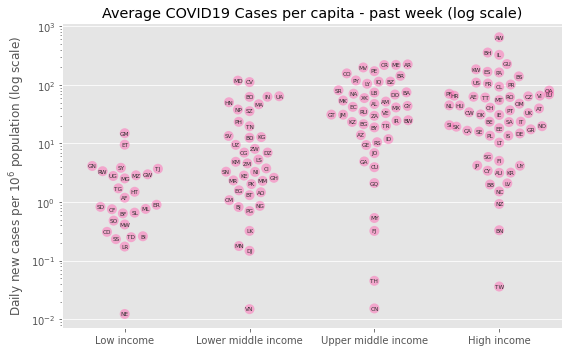

,Rate,Income Group,label


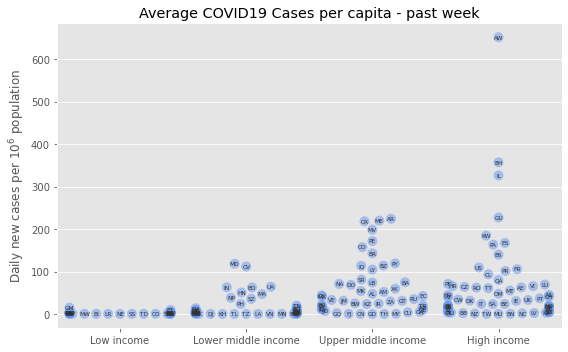

,Rate,Income Group,label


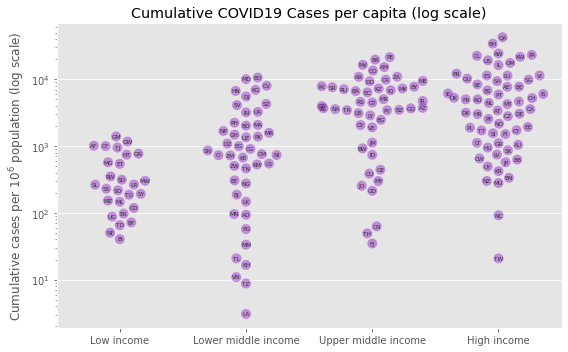

,Rate,Income Group,label


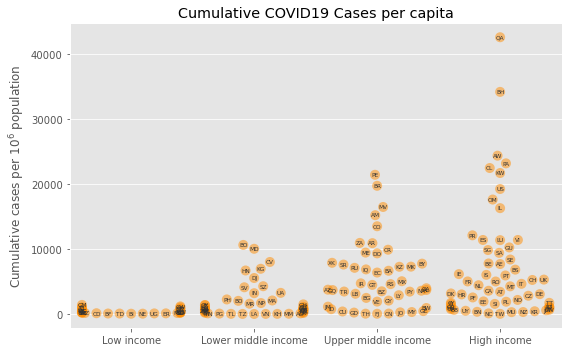

Data retrieved from the lake
Data From 2019-12-31 to 2020-09-09
Data too sparse in Angola (max_consecutive=10)
Data too sparse in Anguilla (max_consecutive=0)
Data too sparse in Antigua And Barbuda (max_consecutive=1)
Data too sparse in Aruba (max_consecutive=2)
Data too sparse in Bahamas (max_consecutive=7)
Data too sparse in Barbados (max_consecutive=3)
Data too sparse in Belize (max_consecutive=2)
Data too sparse in Benin (max_consecutive=4)
Data too sparse in Bermuda (max_consecutive=2)
Data too sparse in Bhutan (max_consecutive=0)
Spikes in Bolivia
DateRep   2020-09-07
spike    1610.000000
mean       64.928571
zeros       1.000000
Data too sparse in Bonaire, Saint Eustatius And Saba (max_consecutive=0)
Data too sparse in Botswana (max_consecutive=1)
Data too sparse in British Virgin Islands (max_consecutive=1)
Data too sparse in Brunei (max_consecutive=1)
Data too sparse in Burkina Faso (max_consecutive=5)
Data too sparse in Burundi (max_consecutive=1)
Data too sparse in Cambodia 

,Rate,Income Group,label


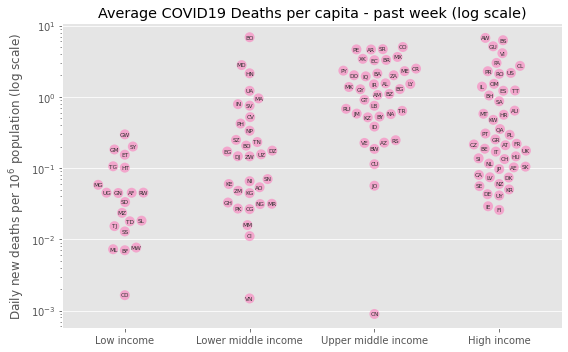

,Rate,Income Group,label


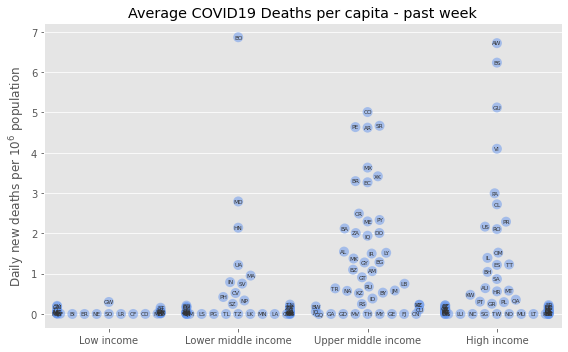

,Rate,Income Group,label


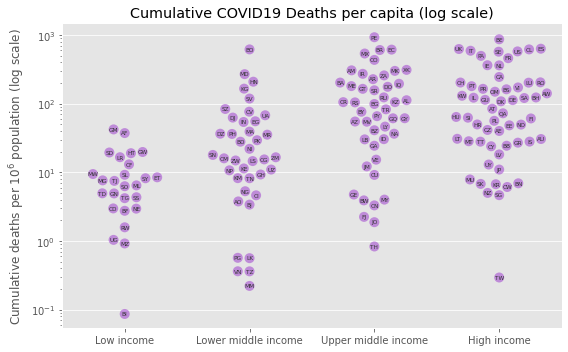

,Rate,Income Group,label


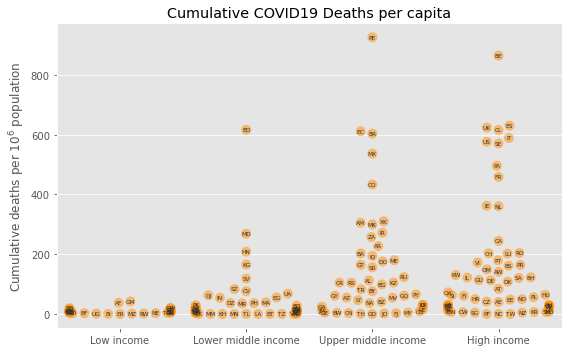

Raw death rates per 100 cases
                                                cases    deaths      RDRPC
Afghanistan                                   38520.0    1418.0   3.681205
Albania                                       10553.0     321.0   3.041789
Algeria                                       46938.0    1571.0   3.346968
Andorra                                        1261.0      53.0   4.203013
Angola                                         2981.0     120.0   4.025495
Anguilla                                          3.0       0.0   0.000000
Antigua And Barbuda                              95.0       3.0   3.157895
Argentina                                    487994.0   10179.0   2.085886
Armenia                                       44953.0     903.0   2.008765
Aruba                                          2589.0      15.0   0.579374
Australia                                     26374.0     770.0   2.919542
Austria                                       30200.0     747.0   2.47

In [30]:
main()

## The End.

In [31]:
print('Finished')

Finished
